In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
import tqdm
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import utils.data
import utils.correlation


# Classifier on Networks

In [3]:
control_data = utils.data.batch_read('../data/Controls_columns')
prodomal_data = utils.data.batch_read('../data/Prodomals_columns')
parkinson_data = utils.data.batch_read('../data/PDs_columns')

> Selecting only BOLD timeseries from AAL3 atlas.

In [4]:
control_AAL3_data = utils.data.select_atlas_columns(control_data, 'AAL3')
prodomal_AAL3_data = utils.data.select_atlas_columns(prodomal_data, 'AAL3')
parkinson_AAL3_data = utils.data.select_atlas_columns(parkinson_data, 'AAL3')

control_AAL3_data[0].head()

,AAL3.cluster001,AAL3.cluster002,AAL3.cluster003,AAL3.cluster004,AAL3.cluster005,AAL3.cluster006,AAL3.cluster007,AAL3.cluster008,AAL3.cluster009,AAL3.cluster010,...,AAL3.cluster161,AAL3.cluster162,AAL3.cluster163,AAL3.cluster164,AAL3.cluster165,AAL3.cluster166,AAL3.cluster167,AAL3.cluster168,AAL3.cluster169,AAL3.cluster170
0,-0.060492,-0.064699,0.027009,0.006356,0.064636,0.025074,-0.072370,-0.023259,0.030439,0.141354,...,-0.128405,-0.212190,0.071778,-0.085851,-0.369906,-0.227215,0.218964,0.143408,0.114787,0.086331
1,0.004386,-0.048182,-0.005618,-0.001391,-0.028455,0.004416,0.008140,-0.016648,-0.002957,0.110977,...,0.121169,0.002904,0.144537,-0.160525,0.209921,0.348922,-0.037231,0.342327,0.182087,-0.142731
2,0.020226,-0.028979,-0.017380,0.002162,-0.063357,0.000866,0.041881,0.002447,-0.014558,0.048355,...,0.242692,0.082687,0.049029,-0.125446,0.396209,0.546062,-0.140805,0.501917,0.402791,-0.298033
3,-0.051301,-0.017008,0.021943,0.026391,0.032551,0.023242,-0.035161,0.014269,0.024234,-0.009537,...,0.064849,-0.150406,-0.138013,0.020100,-0.285842,-0.085880,0.057809,0.427078,0.668149,-0.168126
4,-0.096539,-0.009171,0.079801,0.052421,0.142671,0.025372,-0.122511,-0.020408,0.075939,-0.014011,...,-0.111373,-0.411528,0.032230,0.015906,-1.012333,-0.702678,0.194447,0.166741,0.575768,0.124174


In [5]:
control_correlation_matrix = utils.correlation.pearson_correlation(control_AAL3_data)
prodomal_correlation_matrix = utils.correlation.pearson_correlation(prodomal_AAL3_data)
parkinson_correlation_matrix = utils.correlation.pearson_correlation(parkinson_AAL3_data)


## Absolute Threshold

In [6]:
THRESHOLD = 0.4

In [7]:
def absolute_threshold(graphs, threshold=THRESHOLD):
    threshold_graphs = []
    for i in tqdm.tqdm(range(len(graphs))):
        adj = graphs[i].copy()
        mask = np.abs(adj) >= threshold
        adj_thresholded = adj * mask
        threshold_graphs.append(nx.from_numpy_array(adj_thresholded).to_undirected())
    return threshold_graphs

In [8]:
Control_threshold_graphs = absolute_threshold(control_correlation_matrix)  
Prodomal_threshold_graphs = absolute_threshold(prodomal_correlation_matrix)
Parkinson_threshold_graphs = absolute_threshold(parkinson_correlation_matrix)
    

100%|██████████| 151/151 [00:00<00:00, 258.98it/s]


> take the largest connected component and remove self edges

In [9]:
Control_threshold_graphs_lcc = utils.graph.get_largest_connected_component(Control_threshold_graphs)
Prodomal_threshold_graphs_lcc = utils.graph.get_largest_connected_component(Prodomal_threshold_graphs)
Parkinson_threshold_graphs_lcc = utils.graph.get_largest_connected_component(Parkinson_threshold_graphs)

In [25]:
all_threshold_graphs = utils.graph.concatenate_graphs(Control_threshold_graphs_lcc, Prodomal_threshold_graphs_lcc, Parkinson_threshold_graphs_lcc)
y = utils.data.concatenate_data([0 for _ in range(len(control_data))], [1 for _ in range(len(prodomal_data))], [2 for _ in range(len(parkinson_data))])

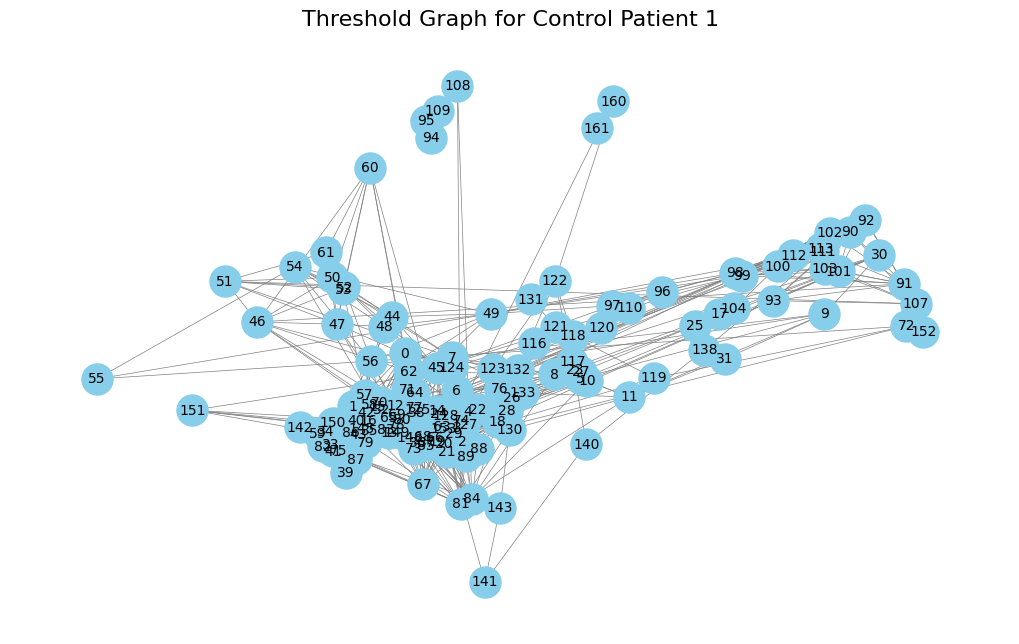

In [31]:
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(Control_threshold_graphs[0], seed=42)
nx.draw(all_threshold_graphs[0], pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=10, font_color='black', width=0.5)
plt.title('Threshold Graph for Control Patient 1', fontsize=16)
plt.axis('off')
plt.show()

### Complex Network Measurements

In [28]:
X_features = pd.DataFrame([utils.graph.extract_network_features(graph) for graph in all_threshold_graphs])

#### Visualizing features

In [29]:
X_features

,num_nodes,num_edges,density,avg_clustering,transitivity,avg_shortest_path_length,diameter,radius,assortativity,global_efficiency,local_efficiency,mean_degree,closeness_centrality,betweenness_centrality,eigenvector_centrality,modularity
0,142,632,0.063131,0.415290,0.430055,3.244231,9,5,0.373401,0.370648,0.551644,8.901408,0.319467,0.016030,0.054331,0.517955
1,137,615,0.066015,0.440749,0.428107,3.253972,8,5,0.373678,0.371967,0.589290,8.978102,0.318234,0.016696,0.052290,0.516053
2,145,778,0.074521,0.513812,0.474507,3.037739,7,4,0.363880,0.391396,0.671795,10.731034,0.336798,0.014250,0.049701,0.528501
3,117,802,0.118184,0.550478,0.536228,2.617742,7,4,0.217914,0.457196,0.687353,13.709402,0.397097,0.014067,0.063771,0.471623
4,143,1344,0.132375,0.531788,0.486628,2.396041,6,3,0.191561,0.487225,0.717965,18.797203,0.429370,0.009901,0.063214,0.330936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,151,1010,0.089183,0.473537,0.547357,3.119558,9,5,0.468216,0.397961,0.606110,13.377483,0.335461,0.014225,0.050188,0.855353
396,147,640,0.059640,0.369568,0.400027,3.203988,8,5,0.274893,0.371433,0.519114,8.707483,0.322181,0.015200,0.057110,0.588306
397,140,920,0.094553,0.421735,0.495190,2.951799,8,4,0.378330,0.418986,0.574413,13.142857,0.356440,0.014143,0.056868,0.496004
398,137,780,0.083727,0.427023,0.470588,3.012559,9,5,0.400021,0.406097,0.578965,11.386861,0.347914,0.014908,0.052731,0.487314


<Axes: >

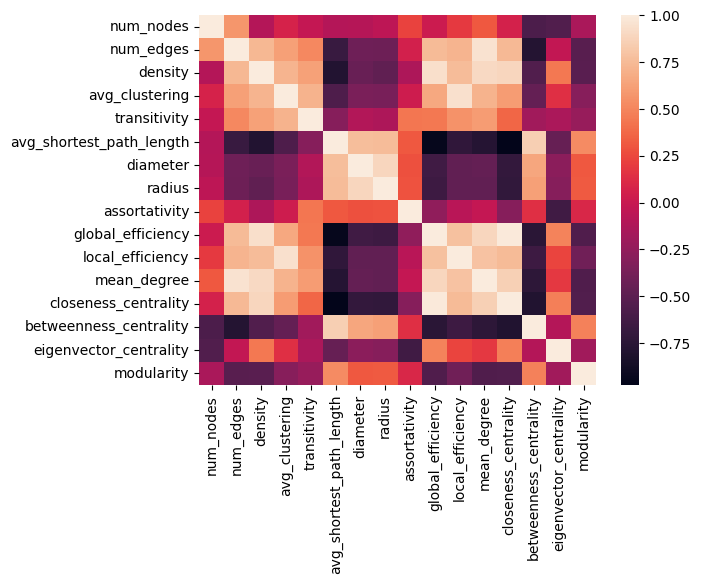

In [30]:
sns.heatmap(X_features.corr(method='pearson'))
   

In [ ]:
def top_correlated_pairs(df, k=10):
    features = [f for f in X_features.columns]
    pairs = []
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            x = df[features[i]].values
            y = df[features[j]].values
            if np.all(np.isfinite(x)) and np.all(np.isfinite(y)):
                c = np.corrcoef(x, y)[0,1]
                pairs.append((features[i], features[j], abs(c), c))
    pairs.sort(key=lambda t: t[2], reverse=True)
    return pairs[:k]

In [ ]:
top_correlated_pairs(X_features, k=10)

[('global_efficiency',
  'closeness_centrality',
  np.float64(0.9907349613230039),
  np.float64(0.9907349613230039)),
 ('avg_shortest_path_length',
  'closeness_centrality',
  np.float64(0.9730551040438792),
  np.float64(-0.9730551040438792)),
 ('num_edges',
  'mean_degree',
  np.float64(0.9523227778794859),
  np.float64(0.9523227778794859)),
 ('avg_shortest_path_length',
  'global_efficiency',
  np.float64(0.9487600871495374),
  np.float64(-0.9487600871495374)),
 ('avg_clustering',
  'local_efficiency',
  np.float64(0.9418024881847095),
  np.float64(0.9418024881847095)),
 ('density',
  'global_efficiency',
  np.float64(0.9321034010521292),
  np.float64(0.9321034010521292)),
 ('density',
  'mean_degree',
  np.float64(0.9051339317509199),
  np.float64(0.9051339317509199)),
 ('global_efficiency',
  'mean_degree',
  np.float64(0.8871874611297796),
  np.float64(0.8871874611297796)),
 ('diameter',
  'radius',
  np.float64(0.8868358287461584),
  np.float64(0.8868358287461584)),
 ('density',


In [45]:
def pca_2d(df, y, palette="tab10", title="PCA (2D)"):
    Xs = StandardScaler().fit_transform(np.asarray(df))
    p = PCA(n_components=2, random_state=42)
    Z = p.fit_transform(Xs)

    pcs = pd.DataFrame(Z, columns=["PC1", "PC2"])
    pcs["label"] = pd.Series(y).astype("category")

    plt.figure(figsize=(7, 5))
    ax = sns.scatterplot(
        data=pcs, x="PC1", y="PC2",
        hue="label", style="label",  # different color & marker per class
        palette=palette, s=60, alpha=0.85, edgecolor="white", linewidth=0.5
    )
    ax.set_xlabel(f"PC1 ({p.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({p.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_title(title)
    ax.legend(title="Class", loc="best", frameon=True)
    ax.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()

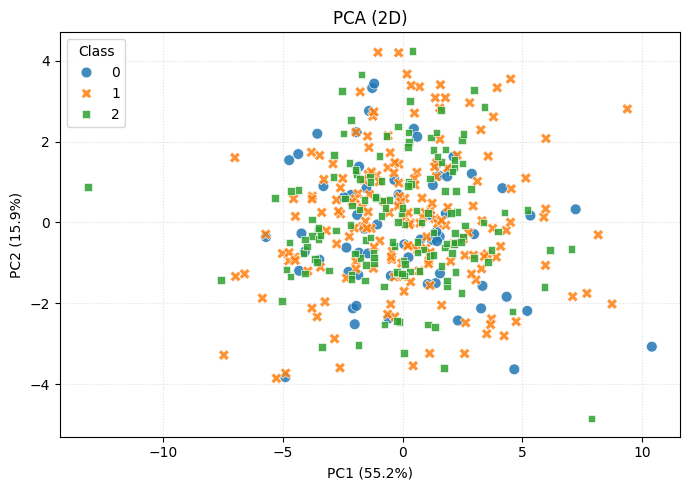

In [46]:
pca_2d(X_features, y)

-----

#### Classifier


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

##### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced')

In [53]:
param_dist = {
  'n_estimators': [100, 200, 500],
  'max_depth': [None, 5, 10, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
}

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(rf, param_dist, cv=cv, scoring='f1_macro', n_jobs=8)
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=8,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_macro')

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.432     0.514     0.469        37
           2      0.286     0.267     0.276        30

    accuracy                          0.338        80
   macro avg      0.239     0.260     0.248        80
weighted avg      0.307     0.338     0.320        80



Text(0.5, 1.0, 'Matriz de Confusão')

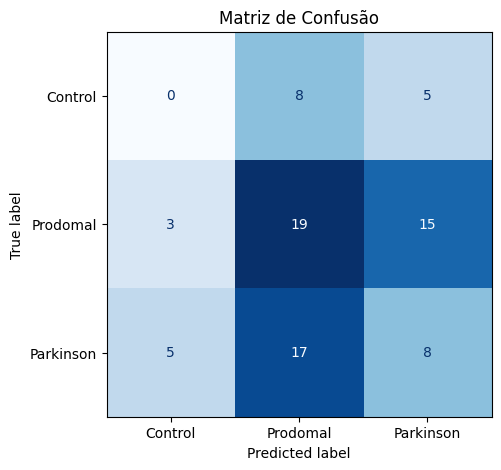

In [55]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

Train Report:               precision    recall  f1-score   support

           0      0.911     0.962     0.936        53
           1      0.938     0.938     0.938       146
           2      0.949     0.926     0.937       121

    accuracy                          0.938       320
   macro avg      0.933     0.942     0.937       320
weighted avg      0.938     0.938     0.938       320



Text(0.5, 1.0, 'Matriz de Confusão')

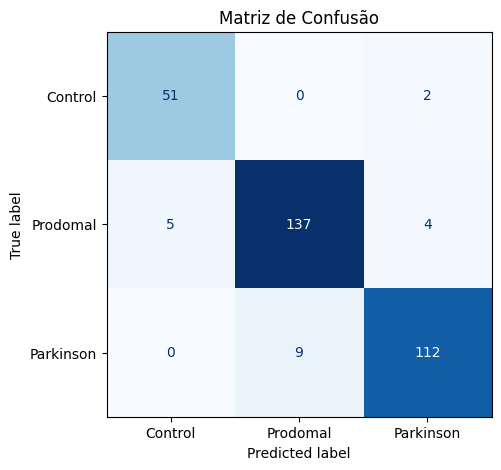

In [56]:
y_pred_train = search.best_estimator_.predict(X_train)
print('Train Report:', classification_report(y_train, y_pred_train, digits=3))
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

##### LR


In [60]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=5000, class_weight='balanced')


In [65]:
param_dist = {
    'model__C': np.logspace(-3, 3, 13),
    'model__solver': ['lbfgs', 'saga']
}

In [66]:
pipe = ImbPipeline(steps=[
    ("standardscaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight=None
    )),
])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(pipe, param_dist, n_iter=20, cv=cv, scoring='f1_macro', n_jobs=4, random_state=42)
search.fit(X_train, y_train)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.447     0.568     0.500        37
           2      0.290     0.300     0.295        30

    accuracy                          0.375        80
   macro avg      0.246     0.289     0.265        80
weighted avg      0.316     0.375     0.342        80



Text(0.5, 1.0, 'Matriz de Confusão')

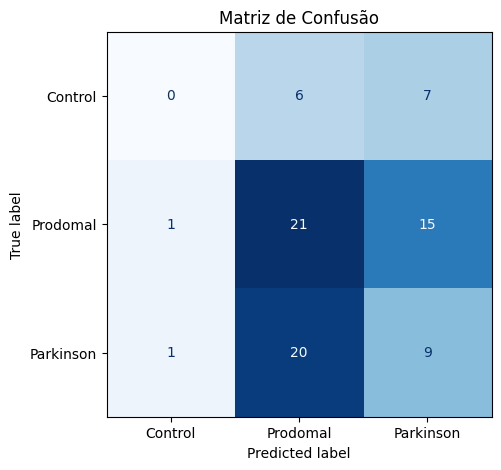

In [68]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

Train Report:               precision    recall  f1-score   support

           0      0.667     0.113     0.194        53
           1      0.544     0.726     0.622       146
           2      0.517     0.496     0.506       121

    accuracy                          0.537       320
   macro avg      0.576     0.445     0.441       320
weighted avg      0.554     0.537     0.507       320



Text(0.5, 1.0, 'Matriz de Confusão')

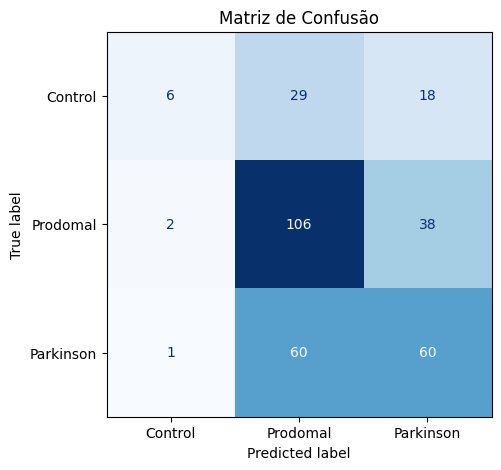

In [69]:
y_pred_train = search.best_estimator_.predict(X_train)
print('Train Report:', classification_report(y_train, y_pred_train, digits=3))
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

### Weisfeiler-Lehman Kernel

In [73]:
from grakel.kernels import WeisfeilerLehman


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
   

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

#### Visualizing features